In [1]:
import gc

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tabnet

%matplotlib inline

In [2]:
df = pd.read_csv('data/processed_train.csv')

In [3]:
CATEGORICAL_COLUMNS = [col for col in df.columns if col.endswith('bin') or col.endswith('cat')]
NUMERIC_COLUMNS = [col for col in df.columns if  not col.endswith('bin') and not col.endswith('cat')]
NUMERIC_COLUMNS.remove('id')
NUMERIC_COLUMNS.remove('target')

In [4]:
def cast_save_memmory(df):
    df.loc[:, NUMERIC_COLUMNS] = df.loc[:, NUMERIC_COLUMNS].astype(np.float32)
    df.loc[:, CATEGORICAL_COLUMNS] = df.loc[:, CATEGORICAL_COLUMNS].astype(np.int32)
    df.loc[:, 'target'] = df.loc[:, 'target'].astype(np.int32)

In [5]:
cast_save_memmory(df)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(df[NUMERIC_COLUMNS + CATEGORICAL_COLUMNS], 
                                                      df['target'], train_size=0.8, random_state=42)

In [7]:
del df
gc.collect()

44

In [8]:
def create_dataset(X, y, shuffle=True, batch_size=10000):
    ds = tf.data.Dataset.from_tensor_slices(({col: X[col] for col in NUMERIC_COLUMNS + CATEGORICAL_COLUMNS},
                                             y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
        
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds = create_dataset(X_train, y_train)
ds_valid = create_dataset(X_valid, y_valid, shuffle=False)

In [10]:
def get_feature(x, dimension=1):
    if x.dtype == np.float32:
        return tf.feature_column.numeric_column(x.name)
    else:
        return tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_identity(x.name, num_buckets=x.max() + 1, default_value=0),
        dimension=dimension)

columns = [get_feature(f) for k, f in X_train[NUMERIC_COLUMNS + CATEGORICAL_COLUMNS].iteritems()]
feature_column = tf.keras.layers.DenseFeatures(columns, trainable=True)

In [11]:
model = tabnet.TabNetClassifier(outputs=1, n_steps=3, n_features=40, 
                         feature_column=feature_column, virtual_batch_size=250)
model.compile(tf.keras.optimizers.Adam(learning_rate=0.025), 
              tf.keras.losses.binary_crossentropy, 
              tf.keras.metrics.AUC())
history = model.fit(ds, validation_data=ds_valid, epochs=2, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=4)])

Epoch 1/2
47/47 [==============================] - 43s 455ms/step - loss: 0.2274 - auc: 0.5023 - val_loss: 0.1621 - val_auc: 0.5640
Epoch 2/2
47/47 [==============================] - 18s 363ms/step - loss: 0.1553 - auc: 0.5617 - val_loss: 0.1630 - val_auc: 0.5659


In [12]:
gc.collect()

214

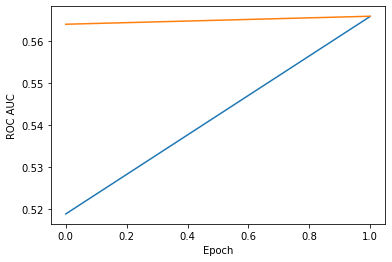

In [15]:
arr = history.history['auc']
val_arr = history.history['val_auc']

plt.plot(np.arange(len(arr)), arr)
plt.plot(np.arange(len(arr)), val_arr)
plt.ylabel('ROC AUC')
plt.xlabel('Epoch');

In [16]:
df_test = pd.read_csv('data/processed_test.csv')

In [17]:
cast_save_memmory(df_test)

In [18]:
ds_test = create_dataset(df_test[NUMERIC_COLUMNS + CATEGORICAL_COLUMNS], df_test['target'], 
                         shuffle=False, batch_size=250)

In [19]:
y_pred = model.predict(ds_test)

In [20]:
sol = pd.read_csv('solutions/scaled_benchmark_mix_8.csv')

In [42]:
np.corrcoef(sol[:len(y_pred)]['target'], y_pred[:, 0])

array([[1.        , 0.68047984],
       [0.68047984, 1.        ]])

In [30]:
sol['target'].mean()

0.045418262482942416

In [46]:
y_pred.mean()

0.026391922

In [47]:
((sol['target'] / sol['target'].mean()) * y_pred.mean()).mean()

0.049160070717336274

In [48]:
sol['target'] = (sol['target'] / sol['target'].mean()) * y_pred.mean()

In [49]:
sol['target'].head()

0    0.032519
1    0.029514
2    0.023717
3    0.004006
4    0.057045
Name: target, dtype: float64

In [52]:
sol.iloc[:len(y_pred), 1] = y_pred

In [53]:
sol['target'].head()

0    0.041039
1    0.018337
2    0.066642
3    0.008664
4    0.037100
Name: target, dtype: float64

In [55]:
sol.to_csv('solutions/tabnet_3_40_25.csv', index=False)